In [2]:
import pickle
import numpy as np
import pandas as pd
from PIL import Image
import albumentations as A
from IPython.display import SVG
import matplotlib.pyplot as plt
%matplotlib inline
import os, re, sys, random, shutil, cv2

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications import InceptionResNetV2, EfficientNetB7
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, LearningRateScheduler
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, ZeroPadding2D, Dropout

In [3]:
# import shutil
# shutil.rmtree('/kaggle/working/')

In [4]:
root_dir = '/kaggle/working/data'

train_images ='/kaggle/working/data/train'
train_masks = '/kaggle/working/data/train_labels'
val_images ='/kaggle/working/data/val'
val_masks = '/kaggle/working/data/val_labels'
test_images ='/kaggle/working/data/test'
test_masks ='/kaggle/working/data/test_labels'

In [5]:
import shutil
shutil.copytree('/kaggle/input/massachusetts-buildings-dataset/png','/kaggle/working/data')

'/kaggle/working/data'

In [6]:
images_listdir = os.listdir(train_images)
masks_listdir = os.listdir(train_masks)
test_images_listdir = os.listdir(test_images)
test_masks_listdir = os.listdir(test_masks)

In [7]:
#images_listdir

In [8]:
print(len(images_listdir))
print(len(masks_listdir))
print(len(test_images_listdir))
print(len(test_masks_listdir))

137
137
10
10


### Image preprocessing

In [9]:
#cv2.imread("/kaggle/input/massachusetts-buildings-dataset/png/test_labels/22828930_15.png")

### Augmentation of images


  
  width: The desired width of the output crop.
  height: The desired height of the output crop.
  p: Probability of applying the transformation. In this case, p=1.0 means that the 
  transformation will be applied with a probability of 100%.
  
  limit: A range specifying the bounds of the rotation angle. In this case, the rotation
        angle will be randomly chosen from the range [60, 300] degrees.
        interpolation: Interpolation: During the rotation, the pixels in the transformed    image 
        need to be assigned values based on the original pixel values. cv2.INTER_NEAREST is an 
        interpolation method that assigns the value of the nearest pixel to the transformed 
        location.
        
  brightness_limit: A range specifying the bounds of the random brightness adjustment. 
        In this case, brightness will be adjusted randomly within the range [-0.2, 0.3]. 
        Negative values indicate a decrease in brightness, and positive values indicate an 
        increase.
        contrast_limit: The maximum allowed range for random contrast adjustment. Here, 0.2 
        means that the contrast will be adjusted randomly within the range [-0.2, 0.2]. 
        Contrast values are multiplicative factors.
        
  Here's how Grid Distortion works:
            
            Grid Generation: The image is divided into a grid of cells.
            
            Deformation: Each point in the grid is displaced by a certain amount in both 
            the x and y directions. The displacement is typically random and follows a smooth 
            pattern, resulting in a distorted grid.
            
            Interpolation: The pixel values in the distorted image are computed by 
            interpolating the values from the original image based on the new grid
            
 Here's how Optical Distortion works:
            
  Effect: This transformation simulates optical distortions that might occur due 
            to the characteristics of camera lenses or other optical devices. It introduces a 
            smooth and continuous deformation of the image.
            
            Parameters:
                distort_limit: Controls the maximum amount of distortion(Distortion refers to
                the alteration of the spatial arrangement of pixels in an image, causing 
                changes in the shape or geometry of objects.) applied to the image.
                Higher values for distort_limit result in more pronounced geometric distortions.
                
                shift_limit: Controls the maximum amount of translation(Translation involves 
                shifting the entire image content along the horizontal and vertical axes.)
                applied to the image.
                Higher values for shift_limit result in larger shifts of the image content.
                
                interpolation: Specifies the interpolation method to use when computing pixel
                values in the distorted image.
  '''

In [11]:
# For images for which there is no clear notion of img, satellite and 
# aerial imagery, or medical imagery, it is typically a good idea to add 
# transformations that do not add or lose information.

'''
Non-destructive transformations include HorizontalFlip, VerticalFlip, 
Transpose, RandomRotate90 
Non-rigid transformations: ElasticTransform, GridDistortion, OpticalDistortion
'''

def augment(width, height):
    transform = A.Compose([
        A.RandomCrop(width=width, height=height, p=1.0),
        A.HorizontalFlip(p=1.0),
        A.VerticalFlip(p=1.0),
        A.Rotate(limit=[60, 300], p=1.0, interpolation=cv2.INTER_NEAREST),
        A.RandomBrightnessContrast(brightness_limit=[-0.2, 0.3], contrast_limit=0.2, p=1.0),
        A.OneOf([
            A.CLAHE (clip_limit=1.5, tile_grid_size=(8, 8), p=0.5),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=1, shift_limit=0.5, interpolation=cv2.INTER_NEAREST, p=0.5),
        ], p=1.0),
    ], p=1.0)

    return transform


In [12]:
train_images

'/kaggle/working/data/train'

In [13]:
# aug_images_train = []
# aug_masks_train = []
# for i in range(8):
#     for file in images_listdir:
        
#         img = cv2.imread(train_images+'/'+file)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         mask = cv2.imread(train_masks+'/'+file)
#         mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
#         transform = augment(512, 512) 
#         transformed = transform(image=img, mask=mask)
#         transformed_image = transformed['image']
#         transformed_mask = transformed['mask']
#         aug_images_train.append(train_images + '/aug_{}_'.format(str(i+1))+file)
#         aug_masks_train.append(train_masks + '/aug_{}_'.format(str(i+1))+file)
#         cv2.imwrite(train_images + '/aug_{}_'.format(str(i+1))+file,cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
#         cv2.imwrite(train_masks + '/aug_{}_'.format(str(i+1))+file,cv2.cvtColor(transformed_mask, cv2.COLOR_BGR2RGB))
        
# images_listdir = images_listdir + aug_images_train
# masks_listdir = masks_listdir + aug_masks_train




In [14]:
class_dict_df = pd.DataFrame([(255, 255, 255),
                  (0, 0, 0)],
                ['building', 'background'])
class_dict_df.columns = ['r', 'g', 'b']

label_names= list(class_dict_df.index)
label_codes = []
r= np.asarray(class_dict_df.r)
g= np.asarray(class_dict_df.g)
b= np.asarray(class_dict_df.b)

for i in range(len(class_dict_df)):
    label_codes.append(tuple([r[i], g[i], b[i]]))

label_codes, label_names

code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

name2id = {v:k for k,v in enumerate(label_names)}
id2name = {k:v for k,v in enumerate(label_names)}

In [15]:


def rgb_to_onehot(rgb_image, colormap = id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,) 
    encoded_image = np.zeros(shape, dtype=np.int8)
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    
    return encoded_image

def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) ) 
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

### DATA GENERATORS

In [16]:
# Normalizing only frame images, since masks contain label info
data_gen_args = dict(rescale=1./255)
mask_gen_args = dict()

train_frames_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**mask_gen_args)
val_frames_datagen = ImageDataGenerator(**data_gen_args)
val_masks_datagen = ImageDataGenerator(**mask_gen_args)

# Seed defined for aligning images and their masks
seed = 1

In [17]:
# FOR TRAINING 

def TrainAugmentGenerator(train_images_dir, train_masks_dir, seed = 1, batch_size = 8, target_size = (512, 512)):
    '''Train Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
            train_images_dir - train images directory
            train_masks_dir - train masks directory
            target_size - tuple of integers (height, width)
            
        Output: Decoded RGB image (height x width x 3) 
    '''
    train_image_generator = train_frames_datagen.flow_from_directory(
    train_images_dir,
    batch_size = batch_size, 
    seed = seed,
    classes = ['train'],
    target_size = target_size)

    train_mask_generator = train_masks_datagen.flow_from_directory(
    train_masks_dir,
    batch_size = batch_size, 
    seed = seed,
    classes = ['train_labels'],
    target_size = target_size)

    while True:
        X1i = train_image_generator.next()  # once one batch is completed, it will go to next batch
        X2i = train_mask_generator.next()
        
        for i in range(X1i[0].shape[0]):
            if np.random.rand()<0.7:
                transform = augment(512, 512)
                transformed = transform(image=(X1i[0][i]*(255.0)).astype(np.uint8), mask=X2i[0][i])
                X1i[0][i] = transformed['image']/255.0
                X2i[0][i] = transformed['mask']
        
        #print(X2i[0].shape, X2i[1].shape)
        #print(X2i[0],X1i[1])
        #print(X2i[0][1,:,:,:].shape)
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)

# FOR TESTING 
def ValAugmentGenerator(val_images_dir, val_masks_dir, seed = 1, batch_size = 8, target_size = (512, 512)):
    '''Validation Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
            val_images_dir - validation images directory
            val_masks_dir - validation masks directory
            target_size - tuple of integers (height, width)
            
        Output: Decoded RGB image (height x width x 3) 
    '''
    val_image_generator = val_frames_datagen.flow_from_directory(
    val_images_dir,
    batch_size = batch_size, 
    seed = seed,
    classes = ['val'],
    target_size = target_size)


    val_mask_generator = val_masks_datagen.flow_from_directory(
    val_masks_dir,
    batch_size = batch_size, 
    seed = seed,
    classes = ['val_labels'],
    target_size = target_size)


    while True:
        X1i = val_image_generator.next()
        X2i = val_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)

### MODEL

In [18]:
batch_size = 8
num_train_samples = len(np.sort(os.listdir('/kaggle/working/data/train')))
num_val_samples = len(np.sort(os.listdir('/kaggle/working/data/val')))
steps_per_epoch = np.ceil(float(num_train_samples) / float(batch_size))
print('steps_per_epoch: ', steps_per_epoch)
validation_steps = np.ceil(float(4 * num_val_samples) / float(batch_size))
print('validation_steps: ', validation_steps)

steps_per_epoch:  18.0
validation_steps:  2.0


In [19]:
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import ZeroPadding2D

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_inception_resnetv2_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained InceptionResNetV2 Model """
    encoder = InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=inputs)

    # include_top: whether to include the fully-connected layer at the top of the network.
    # weights: one of None (random initialization), "imagenet" (pre-training on ImageNet), or the path to the weights file to be loaded.
    # input_tensor: optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model.
    
    """ Encoder """
    s1 = encoder.get_layer("input_1").output           ## (512 x 512)

    s2 = encoder.get_layer("activation").output        ## (255 x 255)
    s2 = ZeroPadding2D(( (1, 0), (1, 0) ))(s2)         ## (256 x 256)

    '''
    For s2:
(1, 0) in the first tuple: It means padding of 1 unit on the top and 0 units on the bottom for the first dimension.
(1, 0) in the second tuple: It means padding of 1 unit on the left and 0 units on the right for the second dimension.
So, the total padding applied is (1 unit on top, 0 units on bottom) and (1 unit on left, 0 units on right), resulting in an output size of (256 x 256).

    For s3:
(1, 1): It means padding of 1 unit on both sides (left and right) for both dimensions.
    '''
    s3 = encoder.get_layer("activation_3").output      ## (126 x 126)
    s3 = ZeroPadding2D((1, 1))(s3)                     ## (128 x 128)

    s4 = encoder.get_layer("activation_74").output      ## (61 x 61)
    s4 = ZeroPadding2D(( (2, 1),(2, 1) ))(s4)           ## (64 x 64)

    """ Bridge """
    b1 = encoder.get_layer("activation_161").output     ## (30 x 30)
    b1 = ZeroPadding2D((1, 1))(b1)                      ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)
    
    """ Output """
    dropout = Dropout(0.3)(d4)
    outputs = Conv2D(2, 1, padding="same", activation="softmax")(dropout) #can use sigmoid as well since a binary class problem

    #softmax gives probability to each class
    #sigmoid does thresholding
    
    #dropout is a regularization technique that helps prevent overfitting by 
    #randomly setting a fraction of input units to zero during training. This introduces noise during training and helps the model generalize better to unseen data.
   
    model = Model(inputs, outputs, name="InceptionResNetV2-UNet")
    return model



In [20]:
# from tensorflow.keras import backend as K


# K.clear_session()
# model = build_inception_resnetv2_unet(input_shape=(512, 512, 3))
# model.summary()

In [21]:
from tensorflow.keras import backend as K


K.clear_session()

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

model = build_inception_resnetv2_unet(input_shape = (512, 512, 3))
model.compile(optimizer=Adam(lr = 0.0001), loss='categorical_crossentropy', metrics=[dice_coef, "accuracy"])
#model.summary()

'''
->adam optmizer: function that adapts the neural network's attributes, like learning rate and weights.
->used to measure the similarity between two sets.

->Dice similarity coefficient, returned as a numeric scalar or numeric vector 
with values in the range [0, 1]. A similarity of 1 means that the segmentations 
in the two images are a perfect match i.e one image is exactly above another image .

'''

219055592/219055592 [==============================] - 6s 0us/step


"\n->adam optmizer: function that adapts the neural network's attributes, like learning rate and weights.\n->used to measure the similarity between two sets.\n\n->Dice similarity coefficient, returned as a numeric scalar or numeric vector \nwith values in the range [0, 1]. A similarity of 1 means that the segmentations \nin the two images are a perfect match i.e one image is exactly above another image .\n\n"

In [22]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.0001, 60)

lr_scheduler = LearningRateScheduler(
    exponential_decay_fn,
    verbose=1
)

# LearningRateScheduler:- decreases learning rate at every epoch 
checkpoint = ModelCheckpoint(
    filepath = 'InceptionResNetV2-UNet.h5',
    save_best_only = True, 
#     save_weights_only = False,
    monitor = 'val_loss', 
    mode = 'auto', 
    verbose = 1
)

earlystop = EarlyStopping(
    monitor = 'val_loss', 
    min_delta = 0.001, 
    patience = 12, 
    mode = 'auto', 
    verbose = 1,
    restore_best_weights = True
)

csvlogger = CSVLogger(
    filename= "model_training.csv",
    separator = ",",
    append = False
)

callbacks = [checkpoint, earlystop, csvlogger, lr_scheduler]

In [23]:
history = model.fit(
    TrainAugmentGenerator(train_images_dir = root_dir, train_masks_dir = root_dir, target_size = (512, 512)), 
    steps_per_epoch=steps_per_epoch,
    validation_data = ValAugmentGenerator(val_images_dir = root_dir, val_masks_dir = root_dir, target_size = (512, 512)), 
    validation_steps = validation_steps, 
    epochs = 50,
    callbacks=callbacks,
    use_multiprocessing=False,
    verbose=1
)

Found 137 images belonging to 1 classes.
Found 137 images belonging to 1 classes.

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/50


2024-01-30 11:27:55.807867: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inInceptionResNetV2-UNet/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1706614108.639598     102 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 [==============================] - ETA: 0s - loss: 0.5618 - dice_coef: 0.6296 - accuracy: 0.7562Found 4 images belonging to 1 classes.
Found 4 images belonging to 1 classes.

Epoch 1: val_loss improved from inf to 0.72043, saving model to InceptionResNetV2-UNet.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 221s 4s/step - loss: 0.5618 - dice_coef: 0.6296 - accuracy: 0.7562 - val_loss: 0.7204 - val_dice_coef: 0.4872 - val_accuracy: 0.2794 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.623506263980886e-05.
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 0.3893 - dice_coef: 0.7410 - accuracy: 0.8586
Epoch 2: val_loss improved from 0.72043 to 0.68680, saving model to InceptionResNetV2-UNet.h5
18/18 [==============================] - 41s 2s/step - loss: 0.3893 - dice_coef: 0.7410 - accuracy: 0.8586 - val_loss: 0.6868 - val_dice_coef: 0.5037 - val_accuracy: 0.5775 - lr: 9.6235e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.261187281287936e-05.
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 0.3513 - dice_coef: 0.7757 - accuracy: 0.8660
Epoch 3: val_loss improved from 0.68680 to 0.65942, saving model to InceptionResNetV2-UNet.h5
18/18 [==============================] - 41

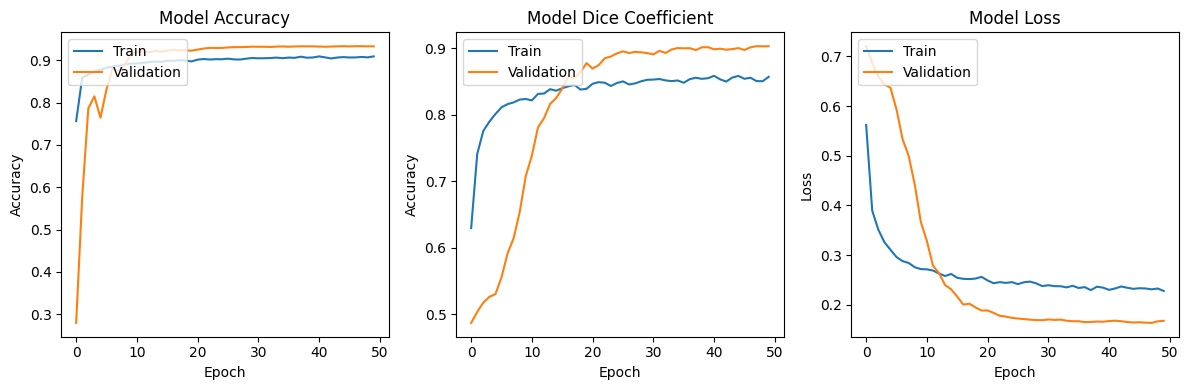

In [28]:
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 2)
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 3)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [29]:
img_path = "/kaggle/input/buildings/building.png"
img = cv2.imread(img_path)
img = cv2.resize(img, (512,512)) / 255.0
img = np.expand_dims(img, axis = 0)  # since we are playing with batches , to extract just 1 batch we use axis=0
mask = onehot_to_rgb(model.predict(img)[0], id2code)

1/1 [==============================] - 3s 3s/step


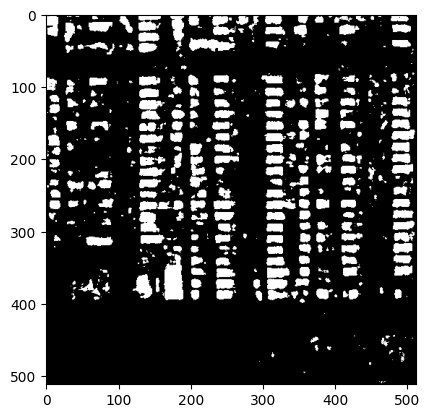

In [30]:
plt.imshow(mask)

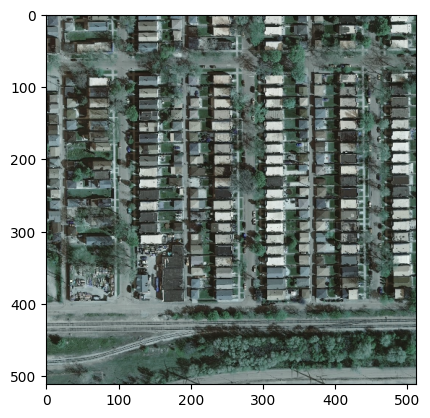

In [31]:
plt.imshow(img[0])